In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys 
sys.path.insert(0, "../src")
import configparser
import pandas as pd 

from utils.dice_score import multiclass_dice_coeff
import numpy as np
import torch
import matplotlib.pyplot as plt
from os.path import join as oj
import my_data
pd.set_option('display.float_format', lambda x: '%.3f' % x)
cuda =  torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
config = configparser.ConfigParser()
config.read('../config.ini');
data_path =config['DATASET']['data_path'] 


In [2]:
x,y, _, _ = my_data.load_layer_data(oj(data_path, 'lno'))
y_second, _, _ = my_data.load_reannotation(oj(data_path, 'lno_second_annotation'))
y_second_formatted = np.copy(y_second)
y_second_formatted_vals = np.unique(y_second_formatted)
for i,val in enumerate(y_second_formatted_vals):
    y_second_formatted[y_second == val] = i

<tifffile.TiffFile 'TrainSet_v2_secondAnnotation.tif'> ImageJ series metadata invalid or corrupted file


In [3]:
x_rough,y_rough, _, _ = my_data.load_layer_data(oj(data_path, 'lno_halfHour'))
# how many pixels labelled in rough annot
print((y_rough == 255).mean())
del x_rough
del y_rough

0.587171576239846


In [4]:
y_second_formatted = y_second_formatted[1024:, :1024] # only one quarter annotated
y = y[-1,1024:, :1024]

In [7]:
y_pred = y_second_formatted[None,:]
y_pred_one_hot = torch.nn.functional.one_hot(torch.Tensor(y_pred).to(torch.int64), 
                                            num_classes=3).permute(0, 3, 1, 2).squeeze()[None, :]
dice = multiclass_dice_coeff(y_pred_one_hot.float(), 
                    torch.Tensor(y[None,:]), 
                    num_classes=3,separated_up = True)


In [8]:
dice.mean() # all classes

0.97612625

In [10]:
dice

array([0.9980065 , 0.96928567, 0.96108663], dtype=float32)

In [9]:
dice[1:].mean() # separated up

0.9651861

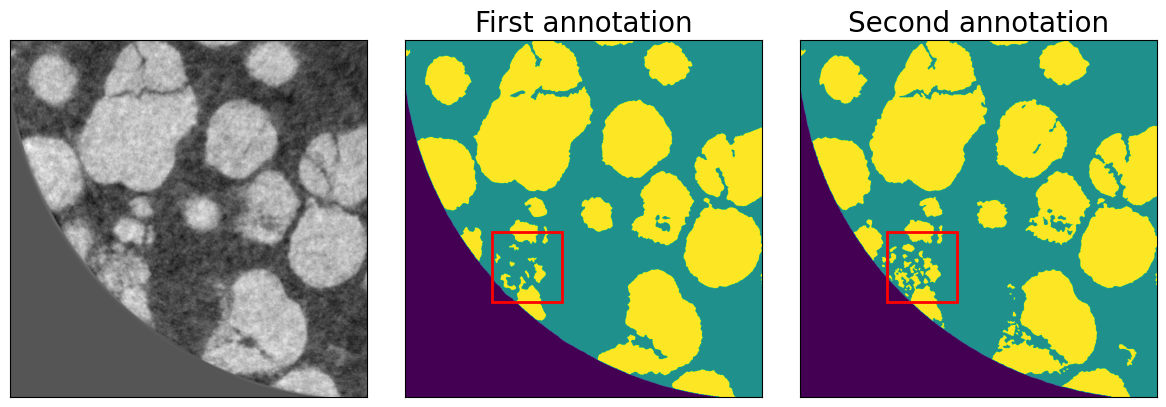

In [7]:
fig, axes = plt.subplots(ncols=3, figsize= (12,4))
axes[0].imshow(x[-1, 0,1024:, :1024], cmap = plt.get_cmap('gray')  )
axes[1].imshow(y)
# add title
axes[1].set_title('First annotation', fontsize = 20)
axes[2].imshow(y_second_formatted)

axes[2].set_title('Second annotation', fontsize = 20)
# axes[3].imshow(y != y_second_formatted)
# # remove the ticks on x and y
# axes[3].set_title('Difference')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

#have a red box in the image
rect = plt.Rectangle((250, 550), 200, 200, edgecolor='r', facecolor='none', linewidth=2)
axes[2].add_patch(rect)
rect = plt.Rectangle((250, 550), 200, 200, edgecolor='r', facecolor='none', linewidth=2)
axes[1].add_patch(rect)



# axes[3].bar(np.arange(2), [entropy[y == y_second_formatted].mean(), entropy[y != y_second_formatted].mean()],color=['green', 'red'] )
# axes[3].set_xticks(np.arange(2))
# # make arrows to the plots

# axes[3].set_xticklabels(['Annotations match', 'Do not match'], rotation=10, fontsize = 15)
# axes[3].set_ylabel('Entropy (NN)', fontsize = 15);
# axes[3].set_yticks([0, 0.3, .6])
plt.tight_layout()
fig_path =config['PATHS']['figure_path'] 

plt.savefig(oj(fig_path,'lno_annotations.png'), bbox_inches='tight', dpi=300)

In [8]:
# figure for human progress
folder_name = "C:\\Users\\lauri\\OneDrive - Danmarks Tekniske Universitet\\Dokumenter\\GitHub\\segmenter\\progress_files\\8766305759"
human_annotated = oj(folder_name, "human_annotated")
files_in_ha = sorted([oj(human_annotated, fname) for fname in os.listdir(human_annotated) ])
# choose 4 tif files
# load the files
np.random.seed(42)
my_files = np.random.choice(files_in_ha, 4)
# my_files = files_in_ha[-4:]
my_files_predicted = [x.replace('human_annotated', 'predictions') for x in my_files]

my_files_images = [x.replace('human_annotated', 'images') for x in my_files]

NameError: name 'os' is not defined

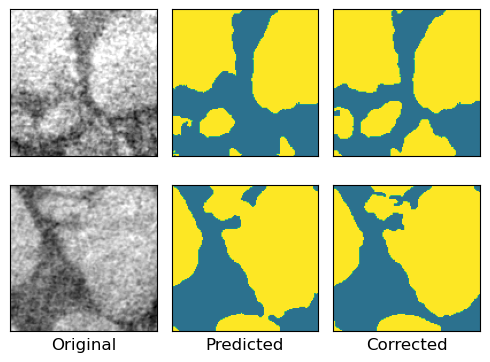

In [ ]:
# load the tif files
import tifffile
fig, axes = plt.subplots(ncols=3, nrows =2, figsize= (5,4))
for i, file in enumerate(my_files_images[:2]):
    img = tifffile.imread(file)
    axes[i,0].imshow(img, cmap = plt.get_cmap('gray')  )
    # axes[0,i,].set_title(file.split("\\")[-1], fontsize = 20)
    axes[i,0].set_xticks([])
    axes[i,0].set_yticks([])
    img_pred = tifffile.imread(my_files_predicted[i])
    axes[i,1].imshow(img_pred, vmin =100, vmax = 242)
    # axes[1,i,].set_title(my_files_predicted[i].split("\\")[-1], fontsize = 20)
    axes[i,1].set_xticks([])
    axes[i,1].set_yticks([])
    img = tifffile.imread(my_files[i])
    axes[i,2].imshow(img, vmin = 100, vmax = 242, alpha = (img_pred != img).astype(float))
    
    axes[i,2].imshow(img, vmin = 100, vmax = 242, )
    # axes[2,i,].set_title(my_files_images[i].split("\\")[-1], fontsize = 20)
    axes[i,2].set_xticks([])
    axes[i,2].set_yticks([])
axes[1,0].set_xlabel('Original', fontsize = 12)
axes[1,1].set_xlabel('Predicted', fontsize = 12)
axes[1,2].set_xlabel('Corrected', fontsize = 12)
plt.tight_layout()
plt.savefig('human_progress.png', bbox_inches='tight', dpi=300)


In [43]:
# load a model and

from scipy.signal import convolve2d
from unet import UNet
# from tqdm.notebook import  tqdm

file_name = '0744366178' # base model

net = UNet(1, 3, ).to(device)

net.load_state_dict(torch.load(oj(config['PATHS']['model_path'] , file_name +  ".pt" )))
y_pred = net(torch.Tensor(x[-1:, 0,1024:, :1024]/255.0)[None, :].to(device))
y_pred_softmax = torch.nn.functional.softmax(y_pred[0], dim=0).detach().cpu().numpy()
entropy = ( - (y_pred_softmax * np.log(y_pred_softmax)).sum(axis=0))

torch.Size([1, 1024, 64, 64])


In [54]:

from scipy.signal import convolve2d
add_val = 32
mean_arr= np.ones((add_val,add_val))/np.square(add_val)


correct_vals = convolve2d((y != y_second_formatted).astype(float), mean_arr, mode = 'same')[::add_val, ::add_val].reshape(-1)
entropy_smooth = convolve2d(entropy, mean_arr, mode = 'same')[::add_val, ::add_val].reshape(-1)

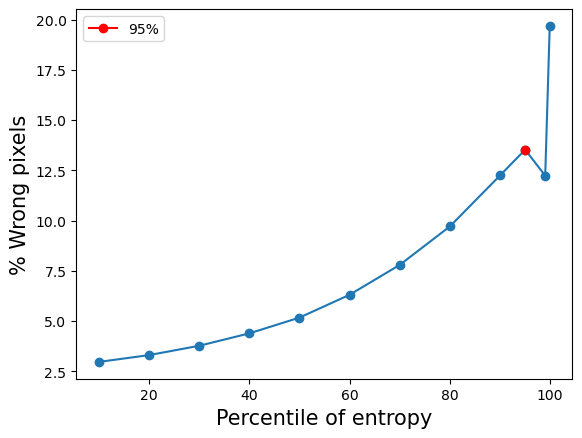

In [55]:


vals = [x*100 for x in [ .1, .2, .3, .4,.5,.6,.7,.8,.9, .95, .99,  .999]]
# vals 

correct_mean = []
for i in range(len(vals)):

    correct_mean.append(correct_vals[np.where((entropy_smooth > np.percentile(entropy_smooth, vals[i])) )].mean())
plt.plot(vals, np.asarray(correct_mean)*100, marker = 'o')


ninetyfive = correct_vals[np.where((entropy_smooth > np.percentile(entropy_smooth, 95)) )].mean()*100
plt.plot([95, ], [ninetyfive,], marker = 'o', c= 'r', label = "95%",)
plt.xlabel('Percentile of entropy', fontsize = 15)

plt.ylabel('% Wrong pixels', fontsize = 15)
plt.legend()
plt.savefig(oj(fig_path,'entropy_corrected.png'), bbox_inches='tight', dpi=300)





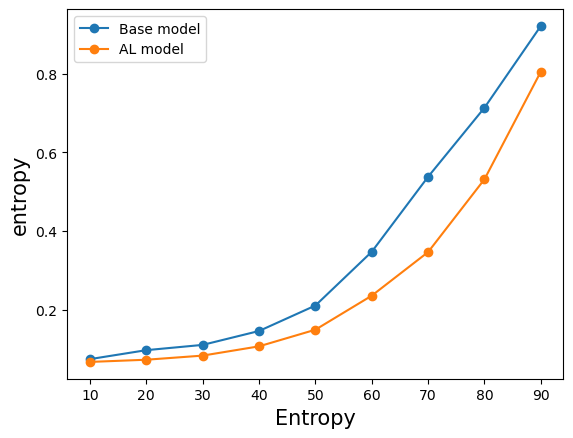

In [344]:

# from scipy.signal import convolve2d
# add_val = 32
# mean_arr= np.ones((add_val,add_val))/np.square(add_val)



# vals = [x*100 for x in [ .1, .2, .3, .4,.5,.6,.7,.8,.9, 1.0]]
# # vals 
# correct_mean = []
# for i in range(len(vals)-1):

#     correct_mean.append(entropy_smooth_base[np.where((entropy_smooth_base > np.percentile(entropy_smooth_base, vals[i])) & (entropy_smooth_base < np.percentile(entropy_smooth_base, vals[i+1])) )].mean())
# plt.plot(vals[:-1], correct_mean, marker = 'o', label = 'Base model',)



# # vals 
# correct_mean = []
# for i in range(len(vals)-1):

#     correct_mean.append(entropy_smooth[np.where((entropy_smooth > np.percentile(entropy_smooth, vals[i])) & (entropy_smooth < np.percentile(entropy_smooth, vals[i+1])) )].mean())
# plt.plot(vals[:-1], correct_mean, marker = 'o', label = 'AL model', )


# plt.xlabel('Entropy', fontsize = 15)

# plt.ylabel('entropy', fontsize = 15)
# plt.legend()



